In [1]:
from PIL import Image
import sys
import numpy as np
from src.helper import readImage, RGBtoGRAY, makeShape8Divisible, changeRange, removePadding, sharpenImage,saveImage
import matplotlib.pyplot as plt
from scipy.fftpack import dct, dst
from src.seam import removeSeam, insertSeam
from src.transforms import DCT, DST 
import os
from pathlib import Path
import matplotlib.pyplot as plt



def seamCarving(scaledImage, ImportanceMap, alpha=2, number_w=150, number_h=150):
    h,w=ImportanceMap.shape
    desired_w = w-number_w
    desired_h = h-number_h
    current_h, current_w = ImportanceMap.shape
    # saveProgress=True
    # first we will remove seams as it will help in complexity later if seams are to be inserted in other axis
    #row / column removal
    while(desired_w<current_w):
        scaledImage, ImportanceMap = removeSeam(ImportanceMap, scaledImage, removeCount=number_w, alpha=alpha, axis=0, save=False)
        current_h, current_w=ImportanceMap.shape

    while(desired_h<current_h):
        scaledImage, ImportanceMap = removeSeam(ImportanceMap, scaledImage, removeCount=number_h, alpha=alpha, axis=1,save=False)
        current_h, current_w=ImportanceMap.shape
#     return scaledImage,ImportanceMap
    return scaledImage,ImportanceMap

In [49]:
from pytorch_msssim import ssim
import torchvision.models as vggMods
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import torch.nn as nn

class PerceptualLoss(nn.Module):
    def __init__(self, layers=None, weights=None):
        super(PerceptualLoss, self).__init__()
        # Load a pre-trained VGG19 model
        vgg = vggMods.vgg19(pretrained=True).features
        
        # Freeze VGG parameters
        for param in vgg.parameters():
            param.requires_grad = False
        
        # If no specific layers are provided, default to certain layers
        if layers is None:
            layers = {'3': 'relu1_2', '8': 'relu2_2', '17': 'relu3_3', '26': 'relu4_3'}
        
        self.layers = layers
        
        # Extract only the layers of interest
        self.model = nn.Sequential()
        for name, module in vgg._modules.items():
            self.model.add_module(name, module)
            if name in layers:
                break
        self.model=self.model.to(device)
        
        # Define weights for each layer, if not provided default to 1.0
        if weights is None:
            weights = {layer_name: 1.0 for layer_name in layers.values()}
        
        self.weights = weights

    def forward(self, x, y):
        loss = 0.0
        for name, layer in self.model._modules.items():
            x = layer(x)
            y = layer(y)
            
            if name in self.layers:
                layer_loss = nn.functional.mse_loss(x, y)
                loss += self.weights[self.layers[name]] * layer_loss
                loss+= layer_loss
                
        return loss

    
    
    
class Perceptual_Loss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.percept=PerceptualLoss(weights={'relu1_2': 0.4, 'relu2_2': 0.3, 'relu3_3': 0.2, 'relu4_3': 0.1})
#         self.percept=PerceptualLoss()
        
    def forward(self, input, target):
        percept_loss=self.percept(input, target)
        return torch.sqrt(percept_loss) 
    
    
    

def getImportanceMap(img_RGB):
    

    cosineTransform=DCT()
    sineTransform=DST()

    # to perform DCT we need to first get the grayscale of the image
    img_gray=RGBtoGRAY(img_RGB)

    # #Performing DCT
    DCT_transformed_img= cosineTransform.transform(cosineTransform.transform(img_gray).T ).T

    partialX= sineTransform.transform( cosineTransform.transform(img_gray=DCT_transformed_img) )
    partialY =sineTransform.transform( cosineTransform.transform(img_gray=DCT_transformed_img.T) ).T
    #calculating Importance map based on partial derivatives
    ImportanceMap=np.abs(partialX)+np.abs(partialY)
    ImportanceMap = 255 * (ImportanceMap - ImportanceMap.min()) / (ImportanceMap.max() - ImportanceMap.min())

    # Convert to uint8
    ImportanceMap = ImportanceMap.astype(np.uint8)
    return ImportanceMap


def reduceSize(scaledImage,ImportanceMap, alpha, count):
    scaledImage, ImportanceMap = seamCarving(scaledImage, ImportanceMap, alpha=alpha, number_w=count, number_h=count)
    tempRGB = Image.fromarray(scaledImage.astype(np.uint8))
    return tempRGB


In [51]:
import numpy as np
import torch
import time

alpha = np.round(np.arange(1,-0.1,-0.1),1)
# print(alpha)
Path="/home/scai/msr/aiy227514/scratch/Assignment783/Part2/Dataset/Inputs"
names = os.listdir(Path)
removePixels=128

imagesList=[]
elapsed_timeList=[]

for name in names[:10]:
    images=[]
    elapsed_time=[]
    img_RGB=np.array(Image.open(os.path.join(Path,name)))
    IM=getImportanceMap(img_RGB)
    for i in alpha:
        start_time = time.time()
        images.insert(0,reduceSize(img_RGB, IM, i, removePixels))
        elapsed_time.insert(0,time.time()-start_time)
#         print(i,elapsed_time[0])
        
    elapsed_timeList.insert(0,elapsed_time)
    imagesList.insert(0,images)

1.0 59.77755641937256
0.9 60.71272921562195
0.8 61.12277030944824
0.7 63.636459827423096
0.6 65.71302103996277
0.5 70.4581663608551
0.4 71.62799620628357
0.3 79.59414982795715
0.2 86.37360763549805
0.1 102.58914852142334
0.0 144.156485080719
1.0 63.50848984718323
0.9 65.95081448554993
0.8 67.56462168693542
0.7 68.0181314945221
0.6 70.47074675559998
0.5 72.32309675216675
0.4 72.30085563659668
0.3 71.59949016571045
0.2 77.99922513961792
0.1 86.28532838821411
0.0 142.4622700214386
1.0 75.1953432559967
0.9 75.80058312416077
0.8 78.23228716850281
0.7 78.64855527877808
0.6 81.18155121803284
0.5 83.40210962295532
0.4 86.0560655593872
0.3 89.56446838378906
0.2 96.49103784561157
0.1 105.2800567150116
0.0 143.57827019691467
1.0 45.08109784126282
0.9 44.36790180206299
0.8 44.97976899147034
0.7 45.73951840400696
0.6 46.03720831871033
0.5 49.64935517311096
0.4 53.00665545463562
0.3 55.30353116989136
0.2 60.880828619003296
0.1 74.54153418540955
0.0 142.22344946861267
1.0 59.65849590301514
0.9 60.013

[1.  0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.2 0.1 0. ] [ 56.524464  57.321144  59.10655   60.395264  61.528908  64.01048
  66.14328   69.18147   75.41296   88.31254  142.35645 ]


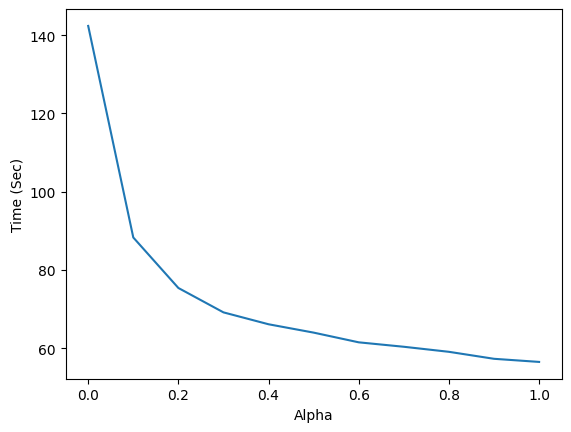

In [63]:
arr=torch.tensor(elapsed_timeList)
y=arr.mean(axis=0).numpy()[::-1]
x=np.round(np.arange(1,-0.1,-0.1),1)
# print(x,y)
plt.plot(x,y)
plt.ylabel('Time (Sec)')
plt.xlabel("Alpha")
plt.show()

In [64]:
import numpy as np
perceptualLossList=[]
device='cpu'
for j in imagesList:
    precLoss=[]
    gold=torch.from_numpy(np.transpose(np.array(j[0]),[2,0,1])).unsqueeze(0)
    lossFunc = Perceptual_Loss()
    for i in j:
        i=torch.from_numpy(np.transpose(np.array(i),[2,0,1])).unsqueeze(0)
        loss=lossFunc(gold.float(),i.float())
        precLoss.append(loss.item())
    perceptualLossList.append(precLoss)   

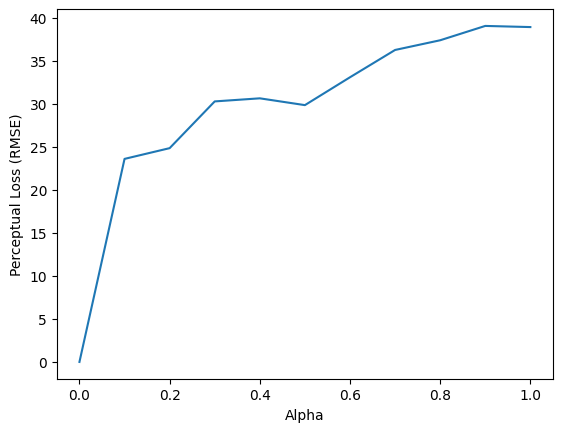

In [68]:
lossArr=torch.tensor(perceptualLossList)
y=lossArr.mean(axis=0).numpy()[::-1]
x=np.round(np.arange(1,-0.1,-0.1),1)
# print(x,y)
plt.plot(x,y)
plt.ylabel('Perceptual Loss (RMSE)')
plt.xlabel("Alpha")
plt.show()

Clearly Visible while the Time is decreasing exponentially the pertectual loss is only increasing logarithmically
- Almost 60% reduction in seam removal time 

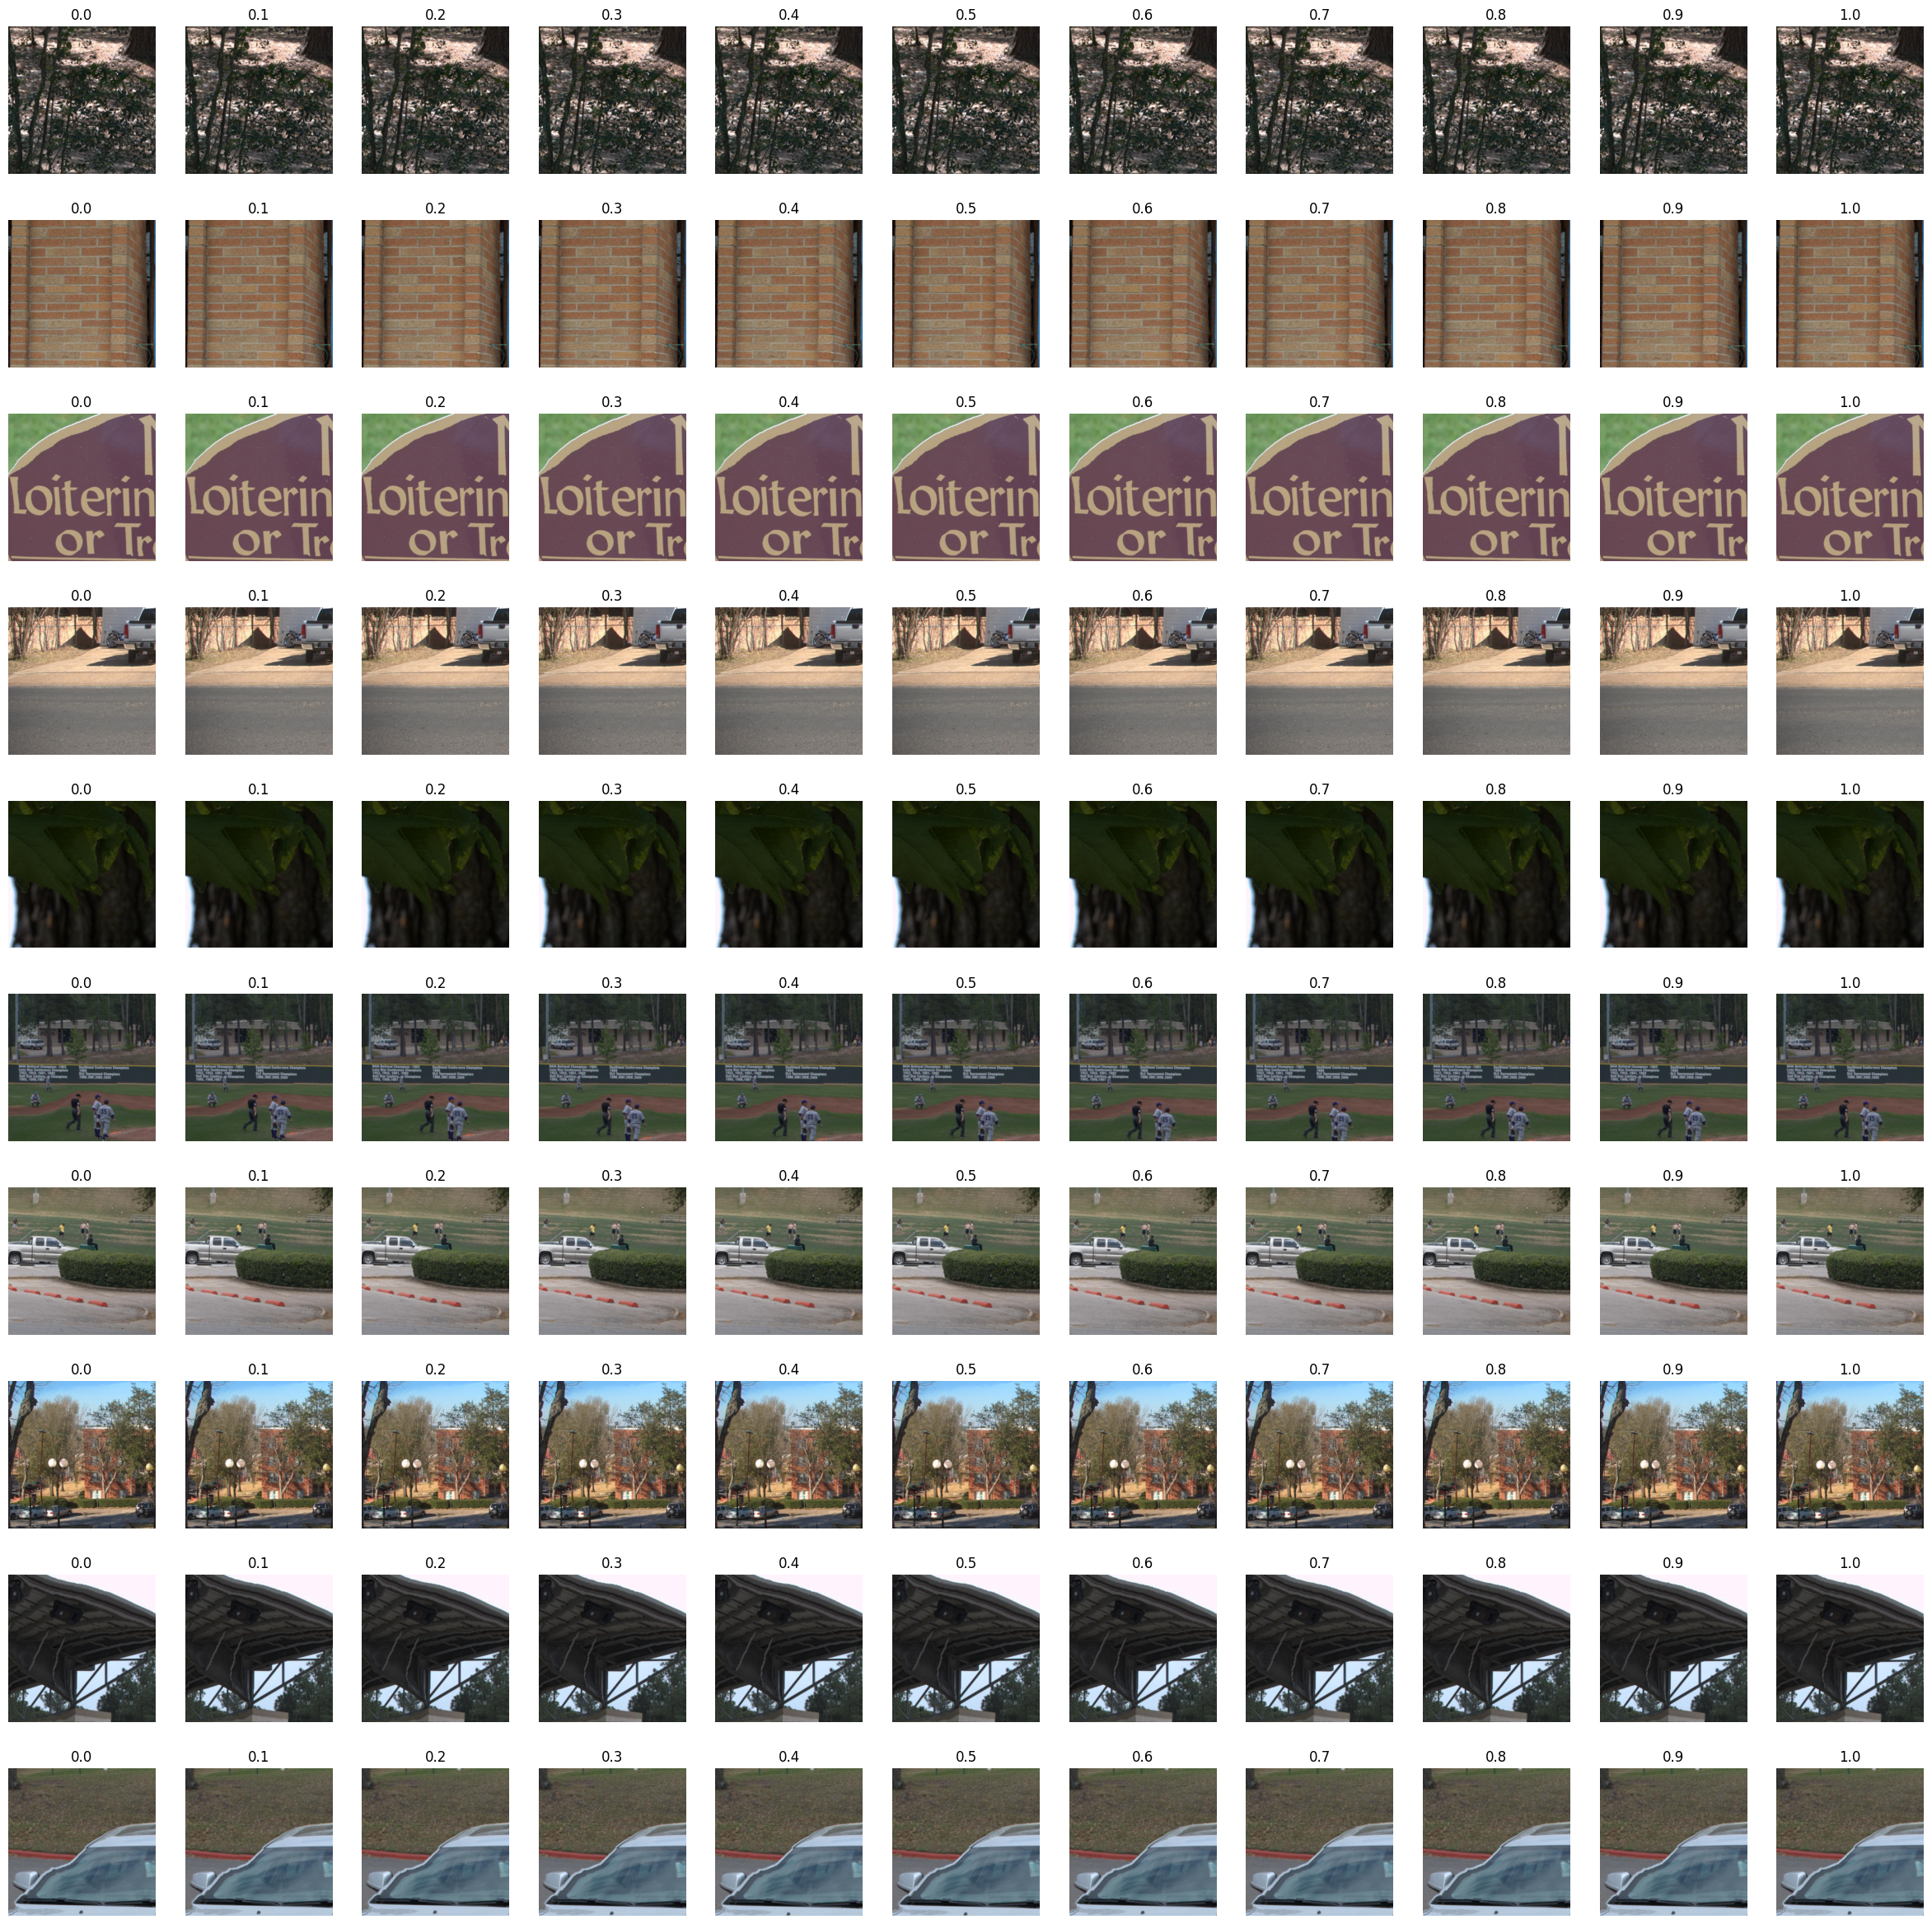

In [75]:
fig,axes=plt.subplots(len(imagesList),len(imagesList[0]), figsize=(30,30))
for j in range(len(imagesList)):
    for i in range(len(imagesList[j])):
        axes[j][i].imshow(imagesList[j][i])
        axes[j][i].set_title(i/10)
        axes[j][i].axis('off') 

plt.show()